<KeysViewHDF5 ['DataCube']>
<Attributes of HDF5 object at 2104210672272>


C:\Users\Usuario\AppData\Local\Temp\ipykernel_12208\2447168356.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


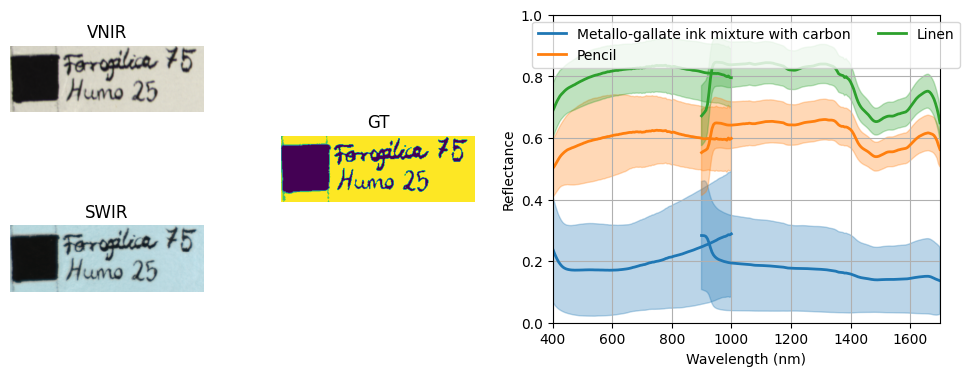

In [15]:
# This script demonstrates how to process and analyze hyperspectral data from VNIR and SWIR minicubes stored in HDF5 format.
# It includes the following steps:
# 1. Load and explore the contents of the VNIR and SWIR minicubes.
# 2. Extract the hyperspectral data (DataCube) and wavelength information.
# 3. Display two false-color RGB images using specific bands from the VNIR and SWIR minicubes.
# 4. Load and display the Ground Truth (GT) image, which contains class labels for each pixel.
# 5. Calculate the mean and standard deviation of the spectral reflectance for each class in the GT.
# 6. Plot the mean spectral reflectance with standard deviation for both the VNIR and SWIR data.
#
# The resulting figures show the false-color image, GT, and spectral plots for each class.
# The only thing you have to do is to define the file names for your VNIR
# and SWIR minicubes.
#
# Color Imaging Laboratory, Department of Optics, University of Granada,
# Spain. colorimg@ugr.es
# ---------------------------------------------------------------------------------------------------
path_package=r'C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages'
import sys
sys.path.append(path_package)

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image
import os

#from google.colab import files

folder=os.getcwd()+'\\hypercubes\\'
# Define the file names
filename_VNIR = folder+'00030-VNIR-mock-up.h5'
filename_SWIR = folder+'00030-SWIR-mock-up.h5'

# Load and explore the contents of the VNIR minicube
with h5py.File(filename_VNIR, 'r') as f:
    # Explore the content of the VNIR file
    print(f.keys())
    # Display metadata information
    print(f.attrs)

# Read the datasets (hypercubes) for VNIR and SWIR
with h5py.File(filename_VNIR, 'r') as f_VNIR:
    DataCube_VNIR = f_VNIR['/DataCube'][:]
    DataCube_VNIR = np.transpose(DataCube_VNIR, (2, 1, 0))

with h5py.File(filename_SWIR, 'r') as f_SWIR:
    DataCube_SWIR = f_SWIR['/DataCube'][:]
    DataCube_SWIR = np.transpose(DataCube_SWIR, (2, 1, 0))

    # Retrieve wavelengths from the 'wl' attribute for both VNIR and SWIR
with h5py.File(filename_VNIR, 'r') as f_VNIR:
    wl_VNIR = f_VNIR.attrs['wl']

with h5py.File(filename_SWIR, 'r') as f_SWIR:
    wl_SWIR = f_SWIR.attrs['wl']

# Display a false-color RGB image using bands [50, 34, 9] in the VNIR minicube
# corresponding to wavelengths 645 nm, 565 nm, and 440 nm
rgb_image_VNIR = DataCube_VNIR[:, :, [50, 34, 9]]

fig = plt.figure(figsize=(12, 4))
gs = GridSpec(2, 3, width_ratios=[1, 1, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.4)
ax1 = fig.add_subplot(gs[0, 0])  # VNIR
ax1.imshow(rgb_image_VNIR)
ax1.set_title('VNIR')
ax1.axis('off')

# Display a false-color RGB image using bands [141 61 21] in the SWIR minicube,
# corresponding to wavelengths 1700 nm, 1300 nm, and 1100 nm
rgb_image_SWIR = DataCube_SWIR[:, :, [141, 61, 21]]

ax2 = fig.add_subplot(gs[1, 0])  # SWIR
ax2.imshow(rgb_image_SWIR)
ax2.set_title('SWIR')
ax2.axis('off')

# Load the Ground Truth (GT) image
GT_filename = filename_VNIR[:-3] + '_GT.png'
GT_filename = GT_filename.replace("-VNIR", "")
cdata = np.array(Image.open(GT_filename))

# Display the GT image
ax3 = fig.add_subplot(gs[:, 1])
ax3.imshow(cdata)
ax3.set_title('GT')
ax3.axis('off')

# Convert minicubes and GT into matrices and vectors
cube_VNIR_matrix = np.reshape(DataCube_VNIR, (-1, len(wl_VNIR)))
cube_SWIR_matrix = np.reshape(DataCube_SWIR, (-1, len(wl_SWIR)))
GT_vect = np.reshape(cdata, (-1,))

# Get the unique labels in the GT
classes = np.unique(GT_vect)

# Extract the labels for the legend
with h5py.File(filename_VNIR, 'r') as f_VNIR:
    GTLabels = f_VNIR.attrs['GTLabels']

# VNIR - Calculate the means and standard deviations for each class
mean_values_VNIR = []
std_VNIR = []
for group in classes:
    rows = cube_VNIR_matrix[GT_vect == group]
    mean_values_VNIR.append(np.mean(rows, axis=0))
    std_VNIR.append(np.std(rows, axis=0))

mean_values_VNIR = np.array(mean_values_VNIR)
std_VNIR = np.array(std_VNIR)

# SWIR - Calculate the means and standard deviations for each class
mean_values_SWIR = []
std_SWIR = []
for group in classes:
    rows = cube_SWIR_matrix[GT_vect == group]
    mean_values_SWIR.append(np.mean(rows, axis=0))
    std_SWIR.append(np.std(rows, axis=0))

mean_values_SWIR = np.array(mean_values_SWIR)
std_SWIR = np.array(std_SWIR)

# Plot the standard deviation and mean of the VNIR data
ax4 = fig.add_subplot(gs[:, 2])
ax4.set_xlabel('Wavelength (nm)')
ax4.set_ylabel('Reflectance')

# VNIR - Standard deviation curves
curve_max_VNIR = mean_values_VNIR + std_VNIR
curve_min_VNIR = mean_values_VNIR - std_VNIR
a_VNIR = np.column_stack([wl_VNIR, np.flipud(wl_VNIR)])
area_VNIR = np.column_stack([curve_min_VNIR, curve_max_VNIR[:, ::-1]])

# Plot VNIR data
for i, class_ in enumerate(classes):
    ax4.fill(np.hstack([wl_VNIR, wl_VNIR[::-1]]),
        area_VNIR[i],
        color='C{}'.format(i),
        alpha=0.3)
    ax4.plot(wl_VNIR, mean_values_VNIR[i], color='C{}'.format(i),
               linewidth=2, label=GTLabels[1,i])

# SWIR - Standard deviation curves
curve_max_SWIR = mean_values_SWIR + std_SWIR
curve_min_SWIR = mean_values_SWIR - std_SWIR
a_SWIR = np.column_stack([wl_SWIR, np.flipud(wl_SWIR)])
area_SWIR = np.column_stack([curve_min_SWIR, curve_max_SWIR[:, ::-1]])

# Plot SWIR data
for i, class_ in enumerate(classes):
    ax4.fill(np.hstack([wl_SWIR, wl_SWIR[::-1]]),
        area_SWIR[i],
        color='C{}'.format(i),
        alpha=0.3)
    ax4.plot(wl_SWIR, mean_values_SWIR[i], color='C{}'.format(i), linewidth=2)
# Set plot limits and grid
ax4.set_ylim([0, 1])
ax4.set_xlim([400, 1700])
ax4.grid(True)

# Create the legend
ax4.legend(loc='upper center', fontsize=10, ncol=2)

# Show the figure
plt.tight_layout()
plt.show()
